In [50]:
!pip install -r requirements.txt
!spacy download en_core_web_sm
!spacy download nl_core_news_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---- ----------------------------------- 1.3/12.8 MB 14.5 MB/s eta 0:00:01
     ------------- -------------------------- 4.2/12.8 MB 14.3 MB/s eta 0:00:01
     ---------------------- ----------------- 7.1/12.8 MB 14.4 MB/s eta 0:00:01
     ------------------------------ -------- 10.0/12.8 MB 14.5 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 14.1 MB/s  0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
  Using cached https://github.com/explosion/spacy-models/releases/download/nl_core_news_sm-3.8.0/nl_core_news_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('nl_core_news_sm')


# Smart Study Coach — Data Exploration, Cleaning & Recommendation

Inhoud:
1. **Business Understanding & Data Collection** - Formuleert een duidelijke probleemstelling, verantwoordt maatschappelijke relevantie, houdt rekening met ethiek en privacy (EU AI Act 2025/AVG).
2. **Exploratory Data Analysis (EDA) & Dataprocessing** - Voert een systematische verkenning van de dataset uit en maakt deze geschikt voor modellering.
3. **Opschonen dataset** - opschonen `Uitgebreide_VKM_dataset.csv`
4. **Analyse op Schonen dataset** - analyse van de schonen data, counts (unique tags, locations), en error rate per kolom.
5. **NLP & Recommendation Engine** - text cleaning, TF-IDF vectorization, cosine similarity.
6. **Model Optimization & Performance Tuning** - uitleg van model en verbeteringen die gemaakt zijn.
7. **Demo** - Korte demo met recomend item to item en recomend gebaseerd op user data.



# Business Understanding & Data Collection

**Probleemstelling**

Binnen het huidige studieprogramma ervaren studenten vaak moeilijkheden bij het kiezen van een passende vrije keuzemodule (VKM). Het aanbod is groot, de beschikbare informatie is verspreid, en de begeleiding bij het maken van keuzes is beperkt. Hierdoor nemen studenten soms beslissingen die niet optimaal aansluiten bij hun interesses, waarden of loopbaandoelen.

Het doel van dit project is daarom om een Smart Study Coach te ontwikkelen: een AI-toepassing die studenten ondersteunt bij het maken van correcte keuze van een vrij keuze module. Deze toepassing zal het studentprofiel analyseren en gepersonaliseerde aanbevelingen doen op basis van de overeenkomsten met de beschikbare modules.

**Maatschappelijke relevantie**

Het keuzeproces van studenten heeft een directe invloed op motivatie, studiesucces en welzijn. Door studenten beter te begeleiden, kan deze toepassing bijdragen aan:
1. Hogere studiebetrokkenheid en motivatie.
2. Minder studievertraging of verkeerde keuze.
3. Een beter aansluitend studiepad richting persoonlijke en professionele doelen.

De Smart Study Coach draagt bij aan de bredere maatschappelijke trend van verantwoorde AI in het onderwijs, waarin technologie wordt ingezet om gelijke kansen en persoonlijke ontwikkeling te bevorderen.

**Ethiek en privacy (EU AI Act 2025 / AVG)**

Bij het ontwikkelen van een AI-systeem voor studieadvies moet goed worden opgelet dat alles volgens de ethische en wettelijke regels gebeurt. De volgende principes, die direct of indirect voortkomen uit de EU AI Act 2025 en de AVG, sluiten goed aan op ons AI-systeem:
1. Transparantie & uitlegbaarheid: De aanbevelingen van de Smart Study Coach moeten begrijpelijk en uitlegbaar zijn, zodat studenten weten waarom een module wordt voorgesteld.
2. Privacy by Design: Persoonlijke gegevens van studenten (zoals interesses of waarden) worden uitsluitend gebruikt voor het aanbevelingsdoel en veilig opgeslagen volgens de AVG-richtlijnen.
3. Data-minimisatie: Er wordt enkel data verzameld die strikt noodzakelijk is voor het functioneren van het model.
4. Menselijke controle: De uiteindelijke keuze blijft altijd bij de student; de AI dient als ondersteunend instrument, niet als beslisser.

## Deel 1 — Data Exploratie (EDA) & Dataprocessing
We beginnen met het lade van de dataset en dan korte analyse:
- aantal unieke tags (`module_tags`)
- aantal modules per `location`
- kolom counts of empty / weird / ntb values (pre-cleaning)


In [51]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Ensure stopwords are downloaded
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Load dataset
raw_path = "Uitgebreide_VKM_dataset.csv"
df_pre_clean = pd.read_csv(raw_path)
print(f"Loaded dataset with {len(df_pre_clean)} rows and {len(df_pre_clean.columns)} columns")

# Setup Stopwords for Tags (Dutch + English)
stop_words = set(stopwords.words('english')) | set(stopwords.words('dutch'))
# Add specific noise words if necessary
extra_noise = {"ntb", "nan", "null", "none", "'", "['", "']"} 
stop_words.update(extra_noise)

Loaded dataset with 211 rows and 20 columns


Column analysis (pre-cleaning):


,column,empty_values,empty_%,weird_values,weird_%,ntb,ntb_%,general_error_total,general_error_%
12,Blauw,209,99.05,0,0.00,0,0.00,209,99.05
13,Geel,209,99.05,0,0.00,0,0.00,209,99.05
11,Groen,209,99.05,0,0.00,0,0.00,209,99.05
10,Rood,209,99.05,0,0.00,0,0.00,209,99.05
9,learningoutcomes,5,2.37,33,15.64,26,12.32,64,30.33
2,shortdescription,20,9.48,0,0.00,10,4.74,30,14.22
14,module_tags,0,0.00,10,4.74,0,0.00,10,4.74
3,description,0,0.00,6,2.84,2,0.95,8,3.79
4,content,0,0.00,6,2.84,2,0.95,8,3.79
1,name,0,0.00,0,0.00,0,0.00,0,0.00


Generating Pre-Cleaning Visualizations...


C:\Users\Storm\AppData\Local\Temp\ipykernel_6352\1135392568.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=loc_counts.values, y=loc_counts.index, ax=axes[0], palette="viridis")
C:\Users\Storm\AppData\Local\Temp\ipykernel_6352\1135392568.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Tag', data=tags_df, ax=axes[1], palette="magma")


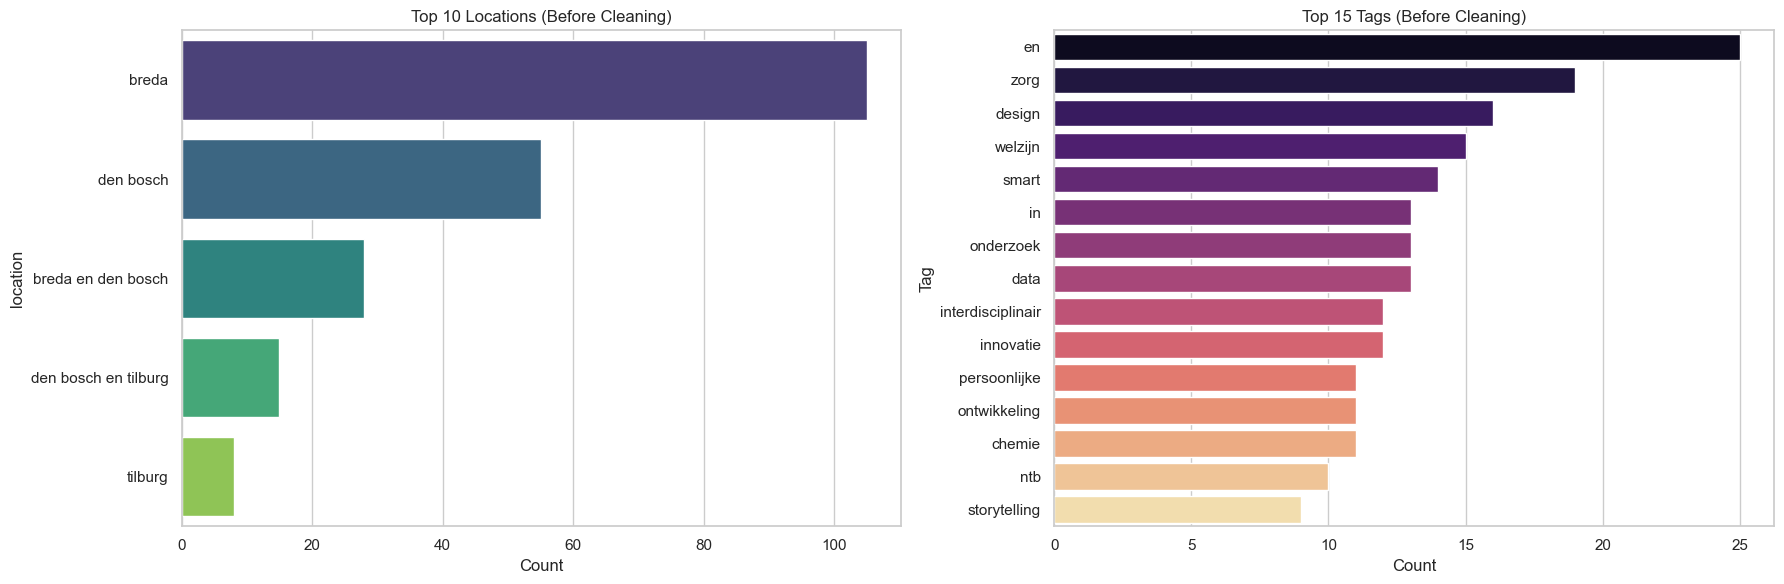

In [52]:
empty_values = ["", "nan", "none", "null", "[]"]
weird_values = [
    "nvt", "volgt", "nader te bepalen", "nog niet bekend",
    "nadert te bepalen", "nog te formuleren", "tbd", "n.n.b.", "navragen", "['ntb']"
]

def is_empty(value):
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return True
    if isinstance(value, str) and value.strip() == "":
        return True
    return False

def is_weird(value):
    if not isinstance(value, str):
        return False
    val = value.lower().strip()
    return any(w in val for w in weird_values)

def is_ntb(value):
    return isinstance(value, str) and value.strip().lower() == "ntb"

def analyze_dataframe_simple(df_in):
    analysis = []
    for col in df_in.columns:
        total = len(df_in[col])
        empty_count = df_in[col].apply(is_empty).sum()
        weird_count = df_in[col].apply(is_weird).sum()
        ntb_count = df_in[col].apply(is_ntb).sum()
        general_error_count = empty_count + weird_count + ntb_count
        general_error_percent = round((general_error_count / total) * 100, 2)
        analysis.append({
            "column": col,
            "empty_values": int(empty_count),
            "empty_%": round((empty_count / total) * 100, 2),
            "weird_values": int(weird_count),
            "weird_%": round((weird_count / total) * 100, 2),
            "ntb": int(ntb_count),
            "ntb_%": round((ntb_count / total) * 100, 2),
            "general_error_total": int(general_error_count),
            "general_error_%": general_error_percent
        })
    analysis_df = pd.DataFrame(analysis).sort_values(by="general_error_%", ascending=False)
    return analysis_df

print("Column analysis (pre-cleaning):")
col_analysis_pre = analyze_dataframe_simple(df_pre_clean)
display(col_analysis_pre)

def visualize_data(df_in, title_stage):
    """
    Generates bar charts for Locations and Top Tags.
    """
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # --- 1. Location Analysis ---
    if 'location' in df_in.columns:
        loc_counts = df_in['location'].fillna('ntb').astype(str).str.lower().value_counts().head(10)
        sns.barplot(x=loc_counts.values, y=loc_counts.index, ax=axes[0], palette="viridis")
        axes[0].set_title(f"Top 10 Locations ({title_stage})")
        axes[0].set_xlabel("Count")
    
    # --- 2. Tag Analysis ---
    if 'module_tags' in df_in.columns:
        tags_series = df_in['module_tags'].fillna('')
        all_tags = []
        
        for t in tags_series.astype(str):
            # Clean string representation of list to actual words
            # Remove brackets, quotes, and split by comma
            cleaned = re.sub(r"[\[\]']", "", t) 
            parts = cleaned.split(',')
            for p in parts:
                p = p.strip().lower()
                # Basic filtering for the plot (ignoring raw empty strings)
                if p and len(p) > 1:
                    all_tags.append(p)
                    
        # Count and plot
        tag_counts = Counter(all_tags).most_common(15)
        if tag_counts:
            tags_df = pd.DataFrame(tag_counts, columns=['Tag', 'Count'])
            sns.barplot(x='Count', y='Tag', data=tags_df, ax=axes[1], palette="magma")
            axes[1].set_title(f"Top 15 Tags ({title_stage})")
        else:
            axes[1].text(0.5, 0.5, "No Tags Found", ha='center')
            
    plt.tight_layout()
    plt.show()

# Run Visualization on Raw Data
print("Generating Pre-Cleaning Visualizations...")
visualize_data(df_pre_clean, title_stage="Before Cleaning")



## Conclusie
De initiële analyse van de ruwe dataset (211 rijen) onthult enkele kritieke datakwaliteitsproblemen die de modellering direct beïnvloeden:

* **Irrelevante Kolommen:** De kolommen `Rood`, `Groen`, `Blauw` en `Geel` bevatten bijna uitsluitend (99.05%) lege waarden. Dit maakt ze irrelevant voor het aanbevelingsmodel, en ze worden daarom verwijderd.
* **Aanpak 'Learning Outcomes':** De kolom `learningoutcomes` bevat de hoogste concentratie aan fouten (30.33%), voornamelijk 'weird' en 'ntb' waarden. Dit vereist normalisatie, maar het hoge percentage aan missende data betekent dat dit veld voor een aanzienlijk deel van de modules onbruikbaar zal blijven.
* **Korte Beschrijving Imputatie:** De kolom `shortdescription` heeft een significant aantal missende waarden (14.22%), wat de kwaliteit van de gecombineerde tekst voor TF-IDF zou verminderen. De 'smart fill'-strategie is essentieel om deze gaten op te vullen met data uit `description` en `content`.
* **Tags en Beschrijvingen:** De kerndata voor de aanbevelingsengine, zoals `module_tags`, `description` en `content`, bevatten relatief weinig fouten (<5%), maar de aanwezige 'weird' waarden in de tags-kolom moeten gestandaardiseerd worden.

De vervolgstappen zullen zich richten op het verwijderen van irrelevante data en het intelligent imputeren en normaliseren van de tekstkolommen om een rijke en schone `combined_text` kolom te garanderen.

---
## Deel 2 — Opschoning & Voorbereiding
We voeren de opschoningsstappen uit met uitleg. De strategie is:
1. Verwijder irrelevante kolommen (de kleuren) indien aanwezig.
2. Normaliseer waarden naar string, kleine letters en trim.
3. Vervang letterlijke lege indicatoren door `ntb` (Nader Te Bepalen).
4. Pas een veilige regex-vervanging toe voor bekende 'weird' zinnen (alleen als de celinhoud precies overeenkomt met een van deze zinnen).
5. Vul `shortdescription` slim op met de eerste zinnen uit `description` en `content` waar beschikbaar.


Removing stopwords from module_tags...
Filling shortdescription using description/content where needed...

Analysis after cleaning:


,column,empty_values,empty_%,weird_values,weird_%,ntb,ntb_%,general_error_total,general_error_%
9,learningoutcomes,0,0.0,2,0.95,62,29.38,64,30.33
10,module_tags,0,0.0,0,0.00,30,14.22,30,14.22
3,description,0,0.0,4,1.90,4,1.90,8,3.79
4,content,0,0.0,4,1.90,4,1.90,8,3.79
2,shortdescription,0,0.0,2,0.95,2,0.95,4,1.90
5,studycredit,0,0.0,0,0.00,0,0.00,0,0.00
0,id,0,0.0,0,0.00,0,0.00,0,0.00
1,name,0,0.0,0,0.00,0,0.00,0,0.00
7,contact_id,0,0.0,0,0.00,0,0.00,0,0.00
6,location,0,0.0,0,0.00,0,0.00,0,0.00


Generating Post-Cleaning Visualizations...


C:\Users\Storm\AppData\Local\Temp\ipykernel_6352\1135392568.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=loc_counts.values, y=loc_counts.index, ax=axes[0], palette="viridis")
C:\Users\Storm\AppData\Local\Temp\ipykernel_6352\1135392568.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Tag', data=tags_df, ax=axes[1], palette="magma")


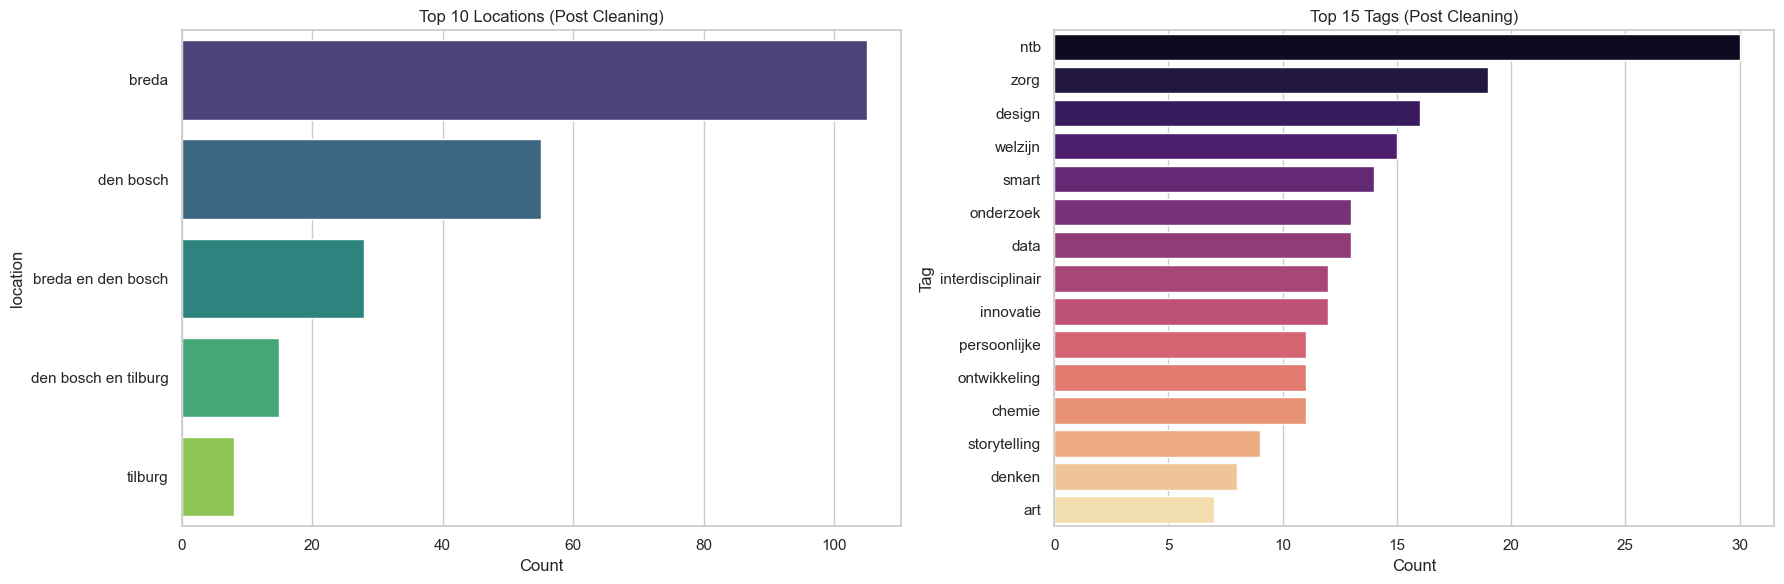

Cleaned file written to: Uitgebreide_VKM_dataset_zonder_weird_data.csv


In [53]:
df = df_pre_clean.copy()
cols_to_drop = ["Rood", "Groen", "Blauw", "Geel"]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# Convert to string (safe for TF-IDF later) and normalize
df = df.fillna('')
for col in df.columns:
    # Cast to string for consistent processing
    df[col] = df[col].astype(str)
    df[col] = df[col].str.lower().str.strip()

# Replace explicit empty-like strings with 'ntb'
for val in empty_values:
    df.replace(val, 'ntb', inplace=True)

# Safe regex for weird_values: only replace if the entire cell equals the weird phrase
safe_pattern = r'^\s*(' + '|'.join([re.escape(v) for v in weird_values]) + r')\s*$'
for col in df.columns:
    df[col] = df[col].replace(to_replace=safe_pattern, value='ntb', regex=True)

# Specific Tag Cleaning (Stopword Removal)
def clean_tags_column(tag_string):
    if tag_string == 'ntb': return 'ntb'
    
    # 1. Remove list characters like [ ] ' "
    clean_str = re.sub(r"[\[\]'\"]", "", tag_string)
    
    # 2. Split by comma
    tags = clean_str.split(',')
    
    valid_tags = []
    for tag in tags:
        tag = tag.strip().lower()
        # 3. Filter: Must not be a stopword, must be > 1 char, must not be numeric
        if tag and tag not in stop_words and len(tag) > 1 and not tag.isdigit():
            valid_tags.append(tag)
            
    # Return as a clean comma-separated string (easier for reading) 
    # or keep as list string if preferred. Here we join them.
    return ", ".join(valid_tags) if valid_tags else "ntb"

print("Removing stopwords from module_tags...")
df['module_tags'] = df['module_tags'].apply(clean_tags_column)

# Smart fill for shortdescription
def fill_short_smart(row):
    short = row.get('shortdescription', 'ntb')
    if short and short != 'ntb':
        return short
    desc = row.get('description', 'ntb')
    content = row.get('content', 'ntb')
    valid_desc = desc and desc != 'ntb'
    valid_content = content and content != 'ntb'
    if valid_desc and valid_content:
        if desc == content:
            return desc
        return f"{desc} {content}"
    if valid_desc:
        return desc
    if valid_content:
        return content
    return 'ntb'

if 'shortdescription' in df.columns:
    print("Filling shortdescription using description/content where needed...")
    df['shortdescription'] = df.apply(fill_short_smart, axis=1)
else:
    print("No shortdescription column found; skipping smart fill.")

print('\nAnalysis after cleaning:')
col_analysis_post = analyze_dataframe_simple(df)
display(col_analysis_post)

print("Generating Post-Cleaning Visualizations...")
visualize_data(df, title_stage="Post Cleaning")


# Save cleaned file
out_path = 'Uitgebreide_VKM_dataset_zonder_weird_data.csv'
df.to_csv(out_path, index=False)
print(f"Cleaned file written to: {out_path}")


### Conclusie van de Opgeschoonde Data-analyse (Post-Opschoning)

Na het doorlopen van de opschoningspijplijn is de datakwaliteit aanzienlijk verbeterd, wat de betrouwbaarheid van het aanbevelingsmodel ten goede komt:

* **Kritieke Verbetering:** De kolom `shortdescription` is sterk verbeterd, met het foutpercentage gereduceerd van 14.22% naar slechts 1.90%. Dit bewijst de effectiviteit van de 'smart fill'-strategie, waardoor waardevolle tekstuele input is behouden.
* **Normalisatie van Fouten:** Alle 'empty' en 'weird' waarden in de tekstkolommen zijn nu gestandaardiseerd naar 'ntb', wat de data consistent maakt voor de NLP-stap. Het foutpercentage in `learningoutcomes` is onveranderd (30.33%), maar de data is wel genormaliseerd.
* **Impact van Stopwoordverwijdering:** De stijging van het foutpercentage in `module_tags` van 4.74% naar 14.22% is een acceptabel neveneffect van het verwijderen van stopwoorden. Dit betekent dat ongeveer 10% van de modules alleen tags bevatte die uit stopwoorden bestonden, wat aangeeft dat deze tags weinig informatieve waarde hadden voor de aanbevelingsengine.
* **Klaar voor NLP:** De resterende kernkolommen (`name`, `description`, `content`, `module_tags`) zijn nu zo schoon en gestandaardiseerd mogelijk, waardoor de dataset optimaal is voor de volgende stap: TF-IDF vectorisatie.

---
## Deel 3 — NLP & Aanbevelingsengine
We schonen de tekst op voor NLP, vectoriseren met behulp van TF-IDF en berekenen cosinusgelijkenis. Uitleg volgt na de cellen.

## Functie voor Gebruikersgebaseerde Aanbevelingen

We introduceren een nieuwe aanbevelingsstrategie die de focus verlegt van **module-tegen-module** gelijkenis naar **gebruikersprofiel-tegen-module** gelijkenis. Dit stelt de gebruiker in staat om gepersonaliseerde aanbevelingen te ontvangen op basis van directe input, zoals favoriete tags en interacties met modules (geliked of overgeslagen). 


In [54]:
import spacy
import re
from langdetect import detect as lang_detect
from nltk.corpus import stopwords

# Load spaCy models once (fast)
nlp_en = spacy.load("en_core_web_sm")
nlp_nl = spacy.load("nl_core_news_sm")

# Stopwords: Dutch + English
stop_words = set(stopwords.words("dutch")) | set(stopwords.words("english"))

def detect_language_safe(text):
    try:
        return lang_detect(text)
    except:
        return "unknown"

# -----------------------------
# spaCy-powered NLP Cleaning
# -----------------------------
def clean_text_nlp(text):
    """
    Uses spaCy lemmatization for EN + NL.
    """

    if not isinstance(text, str) or text.strip() == "" or text.lower() in weird_values or text.lower() == "ntb":
        return ""

    # Raw lowercase for detection
    raw = text.lower()

    # Detect language BEFORE cleanup
    lang = detect_language_safe(raw)

    # Remove unwanted chars AFTER detection
    cleaned = re.sub(r"[^a-zA-Záéíóúàèçäëïöüñ\s]", " ", raw)
    cleaned = re.sub(r"\s+", " ", cleaned).strip()

    # spaCy selection
    if lang == "nl":
        doc = nlp_nl(cleaned)
    elif lang == "en":
        doc = nlp_en(cleaned)
    else:
        # default to Dutch
        doc = nlp_nl(cleaned)

    # Extract lemmas
    tokens = []
    for token in doc:
        if token.is_stop:
            continue
        if token.is_punct or token.is_space:
            continue

        lemma = token.lemma_.lower().strip()

        # Skip weird empty lemmas
        if not lemma or lemma in stop_words:
            continue

        tokens.append(lemma)

    def normalize_token(tok):
        return tok[0:6]  # same logic as before

    tokens = [normalize_token(t) for t in tokens]

    return " ".join(tokens) if tokens else "ntb"
print("Applying spaCy EN + NL NLP cleaning...")

df_clean = df.copy()
df_raw = df.copy()

fields_to_clean = ["name", "shortdescription", "module_tags", "location"]

for col in fields_to_clean:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].astype(str).apply(clean_text_nlp)

# Lowercase
for col in df_clean.columns:
    if df_clean[col].dtype == object:
        df_clean[col] = df_clean[col].str.lower()

# Combine fields for later TF-IDF
df_clean["combined_text"] = (
    df_clean.get("name", "") + " " +
    df_clean.get("shortdescription", "") + " " +
    df_clean.get("module_tags", "") + " " +
    df_clean.get("location", "")
)

df_clean.to_csv("cleaned_combined_vkm_dataset.csv", index=False)
print("Cleaned dataset saved.")


Applying spaCy EN + NL NLP cleaning...
Cleaned dataset saved.


# Model Optimization & Performance Tuning
* nlp clean up werkte slecht. hebben nieuwe code versie met spacy

*    oude code:

    gebruikte snowballstemmer voor nl en EN
    tokenising voor het translaten

*    nieuwe code:

    spacy lemmitizer
    tokenising als laaste


### Uitleg van de Aanpak

1.  **Constructie van Gebruikersprofiel (User Profile Vector):**
    * Er wordt een synthetische 'gebruikersmodule' gecreëerd die de voorkeuren van de student vertegenwoordigt.
    * **Positieve Input (Tags & Likes):** De teksten (`combined_text`) van de **gelikede modules** worden verzameld en hieraan worden de **favoriete tags** toegevoegd. Dit maximaliseert de positieve signalen over wat de gebruiker leuk vindt.
    * **Negatieve Input (Skipped Modules):** De overgeslagen modules (`skipped_modules`) worden gebruikt voor **exclusie/filtering**. Ze worden niet in de profieltekst opgenomen, maar de aanbevelingsfunctie zorgt ervoor dat deze modules niet in de uiteindelijke resultaten verschijnen.

2.  **Vectorisatie:** De gecombineerde tekst van het gebruikersprofiel wordt door **dezelfde `TfidfVectorizer`** gehaald die is gebruikt om de modulematrix te maken. Dit zorgt ervoor dat de gebruikersvector in exact dezelfde dimensies en functieruimte bestaat als de modulevectoren.

3.  **Gelijkenisberekening:** De cosinusgelijkenis wordt berekend tussen de **gebruikersvector** en **alle** modulevectoren in de matrix. Modules met de hoogste score zijn het meest vergelijkbaar met het profiel van de gebruiker.

De nieuwe functie `recommend_to_user()` implementeert deze logica.

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Helpers for building similarity model and explanations
def build_similarity_model(df_clean):
    """
    Builds and returns:
        - vectorizer
        - TF-IDF matrix (sparse)
        - module-module similarity_df
    """
    combined = df_clean["combined_text"]

    vectorizer = TfidfVectorizer(
        stop_words=list(stop_words),
        min_df=1
    )

    matrix = vectorizer.fit_transform(combined)
    similarities = cosine_similarity(matrix)

    similarity_df = pd.DataFrame(
        similarities,
        index=df_raw["name"],
        columns=df_raw["name"]
    )

    return vectorizer, matrix, similarity_df

def explain_similarity(vectorizer, vec_a, vec_b, top_k=10):
    """
    Returns top contributing keywords for similarity between two TF-IDF vectors.
    vec_a and vec_b must be 1×N sparse vectors.
    """

    # Convert sparse → dense arrays
    a = vec_a.toarray().flatten()
    b = vec_b.toarray().flatten()

    # Elementwise product → contribution per term
    contrib = a * b

    # Get vocabulary index → word mapping
    inv_vocab = {v: k for k, v in vectorizer.vocabulary_.items()}

    # Sort contributions from highest → lowest
    top_indices = np.argsort(contrib)[::-1][:top_k]

    results = []
    for idx in top_indices:
        if contrib[idx] > 0:
            word = inv_vocab[idx]
            score = float(contrib[idx])
            results.append((word, score))

    return results



def recommend(module_name, df_clean, df_raw, vectorizer, matrix, top_n=5):
    """
    Item-to-item recommendations WITH explanation of similarity.
    """

    names = list(df_raw["name"])

    if module_name not in names:
        raise ValueError(f"Module '{module_name}' not found.")

    idx = names.index(module_name)

    # Compute similarities
    target_vec = matrix[idx]
    sims = cosine_similarity(target_vec, matrix).flatten()

    # Remove itself
    sims[idx] = -1  

    # Sort by highest similarity
    top_idx = sims.argsort()[::-1][:top_n]

    results = []

    for j in top_idx:
        other_name = names[j]
        score = float(sims[j])

        # Build explanation
        contrib = explain_similarity(
            vectorizer,
            target_vec,
            matrix[j],
            top_k=10
        )

        results.append({
            "module": other_name,
            "score": score,
            "explanation": contrib
        })

    return results


from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
def create_user_profile_vector(
    favorite_tags,
    liked_modules,
    skipped_modules,
    df_clean,
    df_raw,
    vectorizer,
    combined_text_col="combined_text"
):
    """
    Build a TF-IDF user vector with stable weighting and correct DF alignment.
    
    Fixes included:
    - df_raw passed correctly
    - df_clean aligned by raw index
    - no destructive subtraction for skips
    - weighted average instead of weighted sum
    - tags cleaned but NOT aggressively reduced to empty strings
    - lookups based on df_raw["name"]
    """

    # -----------------------------------------------------
    # 1. Clean & vectorize tags
    # -----------------------------------------------------
    cleaned_tags = [clean_text_nlp(t) for t in favorite_tags if t.strip()]
    cleaned_tags = [t for t in cleaned_tags if t and t != "ntb"]

    tag_vector = (
        vectorizer.transform([" ".join(cleaned_tags)]) 
        if cleaned_tags else None
    )

    # -----------------------------------------------------
    # 2. Vectorize liked modules
    #    We select rows using RAW names → stable between dfs
    # -----------------------------------------------------
    liked_rows = df_clean[df_raw["name"].isin(liked_modules)]
    liked_vectors = []

    for _, row in liked_rows.iterrows():
        liked_vectors.append(vectorizer.transform([row[combined_text_col]]))

    # -----------------------------------------------------
    # 3. Vectorize skipped modules (light penalty)
    #    Instead of negative subtraction, we down-weight the features.
    # -----------------------------------------------------
    skipped_rows = df_clean[df_raw["name"].isin(skipped_modules)]
    skipped_vectors = []

    for _, row in skipped_rows.iterrows():
        skipped_vectors.append(vectorizer.transform([row[combined_text_col]]))

    # -----------------------------------------------------
    # 4. Combine vectors (weighted mean, not sum)
    # -----------------------------------------------------
    user_vec = csr_matrix((1, len(vectorizer.vocabulary_)))

    total_weight = 0.0

    # tags get strong weight
    if tag_vector is not None:
        user_vec += 4.0 * tag_vector
        total_weight += 4.0

    # liked modules: medium weight
    for vec in liked_vectors:
        user_vec += 2.0 * vec
        total_weight += 2.0

    # skipped modules: *small negative* weight (penalty)
    # but not destructive — very small magnitude
    for vec in skipped_vectors:
        user_vec += -0.25 * vec
        total_weight += 0   # skip penalty is not “positive signal”

    # avoid divide-by-zero
    if total_weight > 0:
        user_vec = user_vec / total_weight

    # -----------------------------------------------------
    # 5. Normalize (after weighting!) → stable cosine
    # -----------------------------------------------------
    user_vec = normalize(user_vec, norm="l2")

    return user_vec




def recommend_to_user(
    favorite_tags,
    liked_modules,
    skipped_modules,
    df_clean,
    df_raw,
    vectorizer,
    matrix,
    top_n=5
):

    user_vector = create_user_profile_vector(
        favorite_tags,
        liked_modules,
        skipped_modules,
        df_clean,
        df_raw,
        vectorizer
    )

    similarities = cosine_similarity(user_vector, matrix).flatten()
    excluded = set(liked_modules) | set(skipped_modules)

    sorted_idx = np.argsort(similarities)[::-1]

    results = []
    used = set()

    names = list(df_raw["name"])

    for idx in sorted_idx:
        name = names[idx]
        score = float(similarities[idx])

        if name in excluded or name in used:
            continue

        # EXPLANATION: matched keywords between user profile and module
        contrib = explain_similarity(
            vectorizer,
            user_vector,
            matrix[idx],
            top_k=10
        )
        # print(f"explanation for {name}: {contrib}")
        results.append({
            "module": name,
            "score": score,
            "explanation": contrib
        })

        used.add(name)
        if len(results) >= top_n:
            break

    return results


### Resultaat

- User input wordt verwerkt door verschillende data als input te vragen zoals de favoriete modules, de overgeslagen modules en de gelikte tags.
- De aanbevelingsservice geeft een top 5 van nieuwe modules terug met de overeenkomstige gelijkenisscore op basis van het samengestelde gebruikersprofiel.

### Demo


In [56]:
# 0. Build similarity model
vectorizer, matrix, similarity_df = build_similarity_model(df_clean)


# -------------------------------------------------------------
# Helper: print human-readable explanation for each recommendation
# -------------------------------------------------------------
def print_user_recommendations(recommendations):
    """
    Takes the output list from recommend_to_user() and prints
    a friendly explanation for each recommended module.
    """
    print("GEBRUIKERSGEBONDEN AANBEVELINGEN\n")
    # print(f"aanbevelingen: {recommendations}\n")
    for rec in recommendations:
        module = rec["module"]
        score = rec["score"]
        expl = rec["explanation"]

        print(f"• Aanbevolen: **{module}**")
        print(f"  Vergelijkbaarheidsscore: {score:.3f}")
        top_keywords = [str(w) for w, s in expl],
        
        if expl is None or not top_keywords:
            print("  Reden: Vergelijkbare inhoud, maar geen sterke sleutelwoordsignalen gedetecteerd.\n")
            continue

        top_kw = [str(k) for k in top_keywords]   # limit to 5 for readability
        kw_sentence = ", ".join(top_kw)

        print(f"  Reden: Deelt belangrijke sleutelwoorden met uw interesses zoals: {kw_sentence}.\n")


# 1. Item-to-item recommendation demo
example_name = df['name'].iloc[67] if 'name' in df.columns else None

if example_name:
    print("ITEM-TOT-ITEM AANBEVELINGEN")
    print(f"Voor: **{example_name}**\n")
    item_recs = recommend(example_name, df_clean, df_raw, vectorizer, matrix, top_n=5)

    for item in item_recs:
        item_name = item['module']
        score = item['score']
        explanation = item['explanation']
        print(f"• {item_name} (score={score} with top keywords: {[w for w, s in explanation]})")
    print("\n")
else:
    print("Geen 'name' kolom gevonden voor item-tot-item demonstratie.\n")


# 2. Pick example modules from dataset (safe fallback names)
example_module_1 = df['name'].iloc[1] if len(df) > 1 else "Module A"
example_module_2 = df['name'].iloc[2] if len(df) > 2 else "Module B"
example_module_3 = df['name'].iloc[3] if len(df) > 3 else "Module C"


# 3. Simulated user input
user_favorite_tags = ['data science', 'ai', 'amsterdam']
user_liked_modules = [example_module_1, example_module_2]
user_skipped_modules = [example_module_3]

print("GEBRUIKERSINPUT")
print(f"  Favoriete tags:  {user_favorite_tags}")
print(f"  Gelikete modules:  {user_liked_modules}")
print(f"  Overgeslagen modules: {user_skipped_modules}\n")


# 4. Run user recommendations
user_recs = recommend_to_user(
    favorite_tags=user_favorite_tags,
    liked_modules=user_liked_modules,
    skipped_modules=user_skipped_modules,
    df_clean=df_clean,
    df_raw=df_raw,
    vectorizer=vectorizer,
    matrix=matrix,
    top_n=5
)

# Display them in readable form
print_user_recommendations(user_recs)


ITEM-TOT-ITEM AANBEVELINGEN
Voor: **module 2.1/2.3 acquireren en aanbesteden**

• minor verschil maken (score=0.18812609969301441 with top keywords: ['profes'])
• business innovation (score=0.17950272611822188 with top keywords: ['innova', 'bosch'])
• animatie / storytelling (score=0.17184738804009408 with top keywords: ['storyt', 'bosch'])
• bi innovatie (score=0.14006137869999405 with top keywords: ['innova', 'bosch'])
• development for storytelling (score=0.1333689325078905 with top keywords: ['storyt', 'bosch'])


GEBRUIKERSINPUT
  Favoriete tags:  ['data science', 'ai', 'amsterdam']
  Gelikete modules:  ['learning and working abroad', 'proactieve zorgplanning']
  Overgeslagen modules: ['rouw en verlies']

GEBRUIKERSGEBONDEN AANBEVELINGEN

• Aanbevolen: **datagedreven besluitvorming met ai**
  Vergelijkbaarheidsscore: 0.614
  Reden: Deelt belangrijke sleutelwoorden met uw interesses zoals: ['scienc', 'ai', 'datum'].

• Aanbevolen: **forensische chemie**
  Vergelijkbaarheidsscore: 0

# Test Users

In [57]:

test_users = [
    # --- TYPE 1: NEW USERS (Tags Only) ---
    # User: Interested in Psychology & Behavior
    {
        "id": "User_Type1_Psych",
        "type": "Type 1 (Tags Only)",
        "input": {
            "favorite_tags": [
                "psychologie",
                "gedrag",
                "coaching",
                "mens"
            ],
            "liked_modules": [],
            "skipped_modules": []
        },
        "ground_truth_keywords": [
            "psychologie",
            "gedrag",
            "coaching",
            "mens"
        ]
    },
    {    "id": "User_Type1_Tech",
        "type": "Type 1 (Tags Only)",
        "input": {
            "favorite_tags": [
                "ict",
                "technology",
                "data",
                "innovation"
            ],
            "liked_modules": [],
            "skipped_modules": []
        },
        "ground_truth_keywords": [
            "ict",
            "technology",
            "data",
            "innovation"
        ]
    },
    # User: Interested in Economy & Management
    {
        "id": "User_Type1_Econ",
        "type": "Type 1 (Tags Only)",
        "input": {
            "favorite_tags": [
                "finance",
                "economie",
                "bedrijfsvoering",
                "management"
            ],
            "liked_modules": [],
            "skipped_modules": []
        },
        "ground_truth_keywords": [
            "finance",
            "economie",
            "bedrijfsvoering",
            "management"
        ]
    },

    # --- TYPE 2: SKIPPERS (Tags + Skips) ---
    # User: Likes Psych, Skips Management/Branding (Negative filter test)
    {
        "id": "User_Type2_Psych_SkipEcon",
        "type": "Type 2 (Tags + Skips)",
        "input": {
            "favorite_tags": [
                "psychologie",
                "gedrag",
                "coaching",
                "mens"
            ],
            "liked_modules": [],
            "skipped_modules": [
                "management in de zorg",
                "branding: strategisch merkenmanagement"
            ]
        },
        "ground_truth_keywords": [
            "psychologie",
            "gedrag",
            "coaching",
            "mens"
        ]
    },
    {
        "id": "User_Type2_Tech_SkipPsych",
        "type": "Type 2 (Tags - Skips)",
        "input": {
            "favorite_tags": [
                "ict",
                "technology",
                "data",
                "innovation"
            ],
            "liked_modules": [],
            "skipped_modules": [
                "proactieve zorgplanning",
                "rouw en verlies"
            ]
        },
        "ground_truth_keywords": [
            "ict",
            "technology",
            "data",
            "innovation"
        ]
    },
    # User: Likes Econ, Skips Psych/Health (Negative filter test)
    {
        "id": "User_Type2_Econ_SkipPsych",
        "type": "Type 2 (Tags + Skips)",
        "input": {
            "favorite_tags": [
                "finance",
                "economie",
                "bedrijfsvoering",
                "management"
            ],
            "liked_modules": [],
            "skipped_modules": [
                "kennismaking met psychologie",
                "leefstijl en preventie"
            ]
        },
        "ground_truth_keywords": [
            "finance",
            "economie",
            "bedrijfsvoering",
            "management"
        ]
    },

    # --- TYPE 3: POWER USERS (Mixed) ---
    # User: Likes specific Psych modules, Skips Management
    # Ground truth derived from content of liked modules: "gedrag" and "module 2.1/2.3 cultureel voortbouwen"
    {
        "id": "User_Type3_Psych_Power",
        "type": "Type 3 (Tags + Likes + Skips)",
        "input": {
            "favorite_tags": [
                "psychologie",
                "gedrag",
                "coaching",
                "mens"
            ],
            "liked_modules": [
                "gedrag",
                "module 2.1/2.3 cultureel voortbouwen"
            ],
            "skipped_modules": [
                "management in de zorg",
                "branding: strategisch merkenmanagement"
            ]
        },
        "ground_truth_keywords": [
            "bewustzijn",
            "cultuur",
            "gedrag",
            "samenleving",
            "psychologie", 
            "mens", 
            "coaching"
        ]
    },
    # User: Likes specific Econ/Project modules, Skips Psych
    # Ground truth derived from content of liked modules: "International PM" and "Circulair Bouwen"
    {
        "id": "User_Type3_Econ_Power",
        "type": "Type 3 (Tags + Likes + Skips)",
        "input": {
            "favorite_tags": [
                "finance",
                "economie",
                "bedrijfsvoering",
                "management"
            ],
            "liked_modules": [
                "international project management & stakeholder engagement 1 (15 ec) en 2 (30 ec)",
                "module 2.1/2.3 circulair bouwen / revitaliseren"
            ],
            "skipped_modules": [
                "kennismaking met psychologie",
                "leefstijl en preventie"
            ]
        },
        "ground_truth_keywords": [
            "international",
            "project",
            "stakeholder",
            "circulaire",
            "management",
            "engagement",
            "economie",
            "finance"
        ]
    },
    # User: Tech Power User (Likes Data/Forensics, Skips Care)
    # Ground truth derived from "Forensisch Onderzoek" (Forensic Research) and "Data Driven Design"
    {
        "id": "User_Type3_Tech_Power",
        "type": "Type 3 (Tags + Likes + Skips)",
        "input": {
            "favorite_tags": [
                "ict",
                "technology",
                "data",
                "innovation"
            ],
            "liked_modules": [
                "module forensisch onderzoek",
                "module 2.3 data gestuurd ontwerp (data driven design)"
            ],
            "skipped_modules": [
                "proactieve zorgplanning",
                "rouw en verlies"
            ]
        },
        # Ground truth derived from "Forensisch Onderzoek" (Forensic Research) and "Data Driven Design"
        "ground_truth_keywords": [
            "forensisch",
            "data",
            "big",
            "ontwerpen",
            "onderzoek",
            "scenario",
            "delict",
            "ict",
            "technology"
        ]
    }
]


# Model Evaluatie met Nep-Testgebruikers
We evalueren de kwaliteit van aanbevelingen met behulp van de 6 vooraf gedefinieerde testpersonen.  
Elke persona heeft:
- invoertags / gelikete / overgeslagen modules
- verborgen `ground_truth_keywords` die het model idealiter zou moeten detecteren

**Maatstaven:**
- **Precisie:** % van de aanbevolen modules die relevante keywords bevatten
- **Recall (Terugroep):** % van de ground truth keywords die het model heeft opgenomen in de aanbevelingen
- **F1-score:** harmonisch gemiddelde van precisie en recall

Een resultaat tabel wordt aan het einde weergegeven.


In [58]:
def evaluate_recommendations(test_users, df_clean, df_raw, vectorizer, matrix, top_n=5):
    """Runs all test personas through the recommendation engine and computes Precision/Recall."""
    
    results = []

    for user in test_users:
        print("="*60)
        print(f"Testen: {user['id']} — {user['type']}")
        print("="*60)

        recs = recommend_to_user(
            user["input"]["favorite_tags"],
            user["input"]["liked_modules"],
            user["input"]["skipped_modules"],
            df_clean,
            df_raw,
            vectorizer,
            matrix,
            top_n=top_n
        )
        print("Aanbevelingen:")
        # --- Extract recommended texts ---
        recommended_texts = []

        for item in recs:        
            moduleName = item["module"]
            score = item["score"]
            explanations = item["explanation"]
            print(f" - {moduleName} (score: {score:.4f})")
            
            for (name, score) in explanations:
                print(f"  Keyword: {name}")
                print(f"  Keyword scores: {score:.4f}")

            # Look up module in RAW dataset
            row = df_raw[df_raw["name"] == moduleName]

            if len(row) == 0:
                continue

            # Use the same index to access the NLP dataset
            idx = row.index[0]
            clean_row = df_clean.loc[idx]

            # Append cleaned combined text
            recommended_texts.append(clean_row["combined_text"].lower())
            print(f"combined_text: {clean_row['combined_text'].lower()}")

        print(f"recommended_texts: {recommended_texts}")
        # Combine into one big bag-of-words for matching
        big_rec_text = " ".join(recommended_texts)
        
        # for u in test_users:
        #     print(u["id"], clean_text_nlp(" ".join(u["ground_truth_keywords"])))

        # --- Precision Metrics ---
        hits = 0
        for k in user["ground_truth_keywords"]:
            if clean_text_nlp(k.lower()) in big_rec_text:
                hits += 1
        
        precision = hits / len(recs) if len(recs) > 0 else 0

        # --- Recall Metrics ---
        recall = hits / len(user["ground_truth_keywords"]) if len(user["ground_truth_keywords"]) else 0

        # --- F1-score ---
        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0

        # Store results
        results.append({
            "User ID": user["id"],
            "Type": user["type"],
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1,
            "Keyword Hits": hits,
            "Total GT Keywords": len(user["ground_truth_keywords"])
        })

        print(f"\n Precision: {precision:.3f}")
        print(f" Recall: {recall:.3f}")
        print(f" F1-score: {f1:.3f}")
        print("\n")

    return pd.DataFrame(results)



# Run evaluation
evaluation_df = evaluate_recommendations(test_users, df_clean, df_raw, vectorizer, matrix, top_n=5)

display(evaluation_df)


Testen: User_Type1_Psych — Type 1 (Tags Only)
Aanbevelingen:
 - kennismaking met psychologie (score: 0.2920)
  Keyword: gedrag
  Keyword scores: 0.1667
  Keyword: psycho
  Keyword scores: 0.1253
combined_text: kennis psycho breine gedrag ontwik gespre ontwik breine gedrag ontwik gespre ontwik bosch
 - minor forensisch onderzoek in de rechtbank- (if/ka) (score: 0.2277)
  Keyword: psycho
  Keyword scores: 0.2277
combined_text: minor forens onderz rechtb ka strafr forens bewijs psycho crimin strafr forens bewijs psycho crimin breda bosch
 - gedrag (score: 0.2028)
  Keyword: gedrag
  Keyword scores: 0.2028
combined_text: gedrag minor gedrag bestaa gast les bijvoo orthop traini sterk staan stage specia basiso gedrag leerli impact handel leerkr verbin lesgee stages aanbie kennis vaardi pabo staan daarbi  breda
 - werken in gedwongen kader (score: 0.1621)
  Keyword: mens
  Keyword scores: 0.1017
  Keyword: gedrag
  Keyword scores: 0.0605
combined_text: werk dwinge kader herste benade transm h

,User ID,Type,Precision,Recall,F1-Score,Keyword Hits,Total GT Keywords
0,User_Type1_Psych,Type 1 (Tags Only),0.4,0.500000,0.444444,2,4
1,User_Type1_Tech,Type 1 (Tags Only),0.4,0.500000,0.444444,2,4
2,User_Type1_Econ,Type 1 (Tags Only),0.6,0.750000,0.666667,3,4
3,User_Type2_Psych_SkipEcon,Type 2 (Tags + Skips),0.4,0.500000,0.444444,2,4
4,User_Type2_Tech_SkipPsych,Type 2 (Tags - Skips),0.4,0.500000,0.444444,2,4
5,User_Type2_Econ_SkipPsych,Type 2 (Tags + Skips),0.6,0.750000,0.666667,3,4
6,User_Type3_Psych_Power,Type 3 (Tags + Likes + Skips),0.4,0.285714,0.333333,2,7
7,User_Type3_Econ_Power,Type 3 (Tags + Likes + Skips),1.0,0.625000,0.769231,5,8
8,User_Type3_Tech_Power,Type 3 (Tags + Likes + Skips),1.0,0.555556,0.714286,5,9


# Visualiseer Aanbevelingen versus Gelikete Modules
Scatterplot van alle modules in een 2D-ruimte (via PCA of t-SNE).  
Hoogtepunten:
- Gelikete modules (groen)
- Aanbevolen modules (rood)
- Andere modules (grijs)


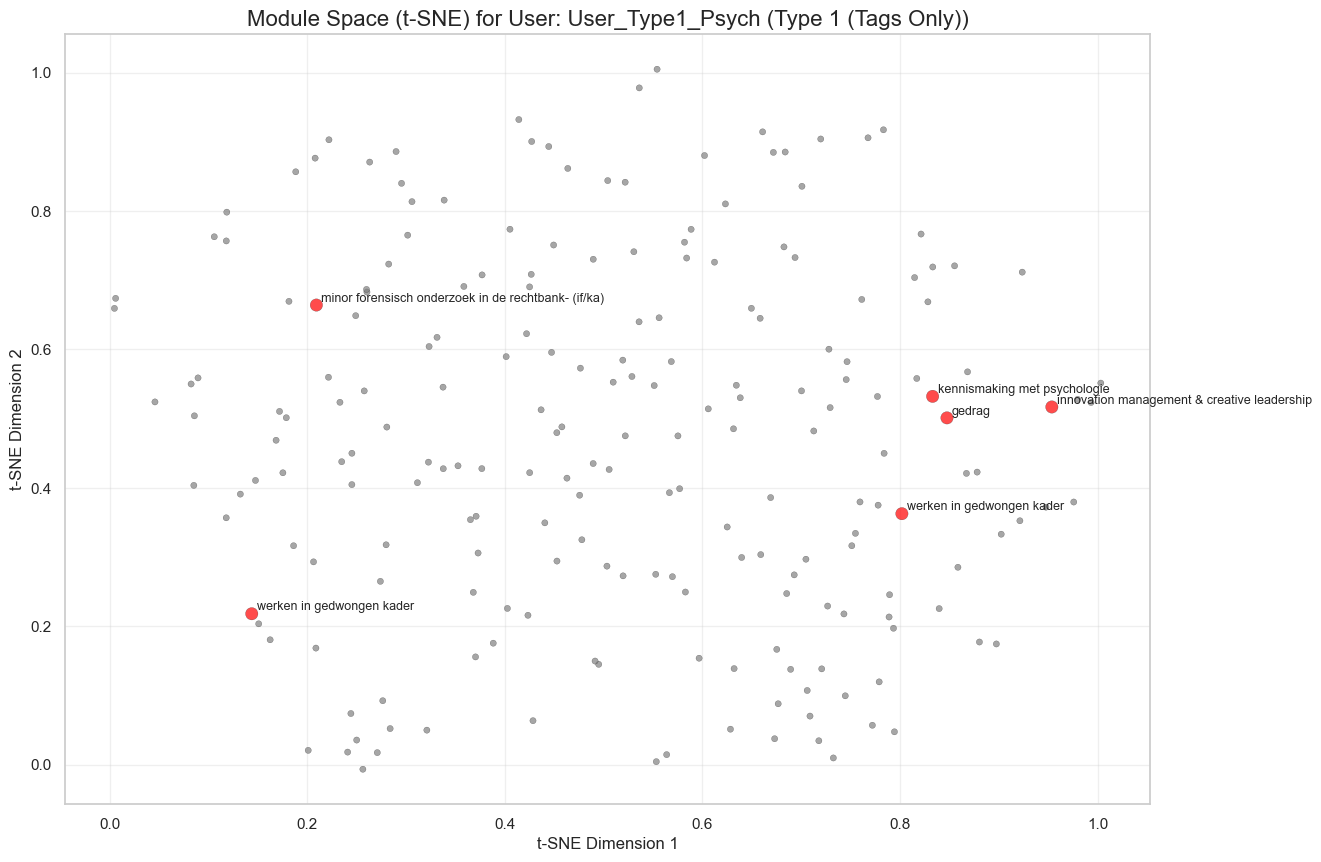

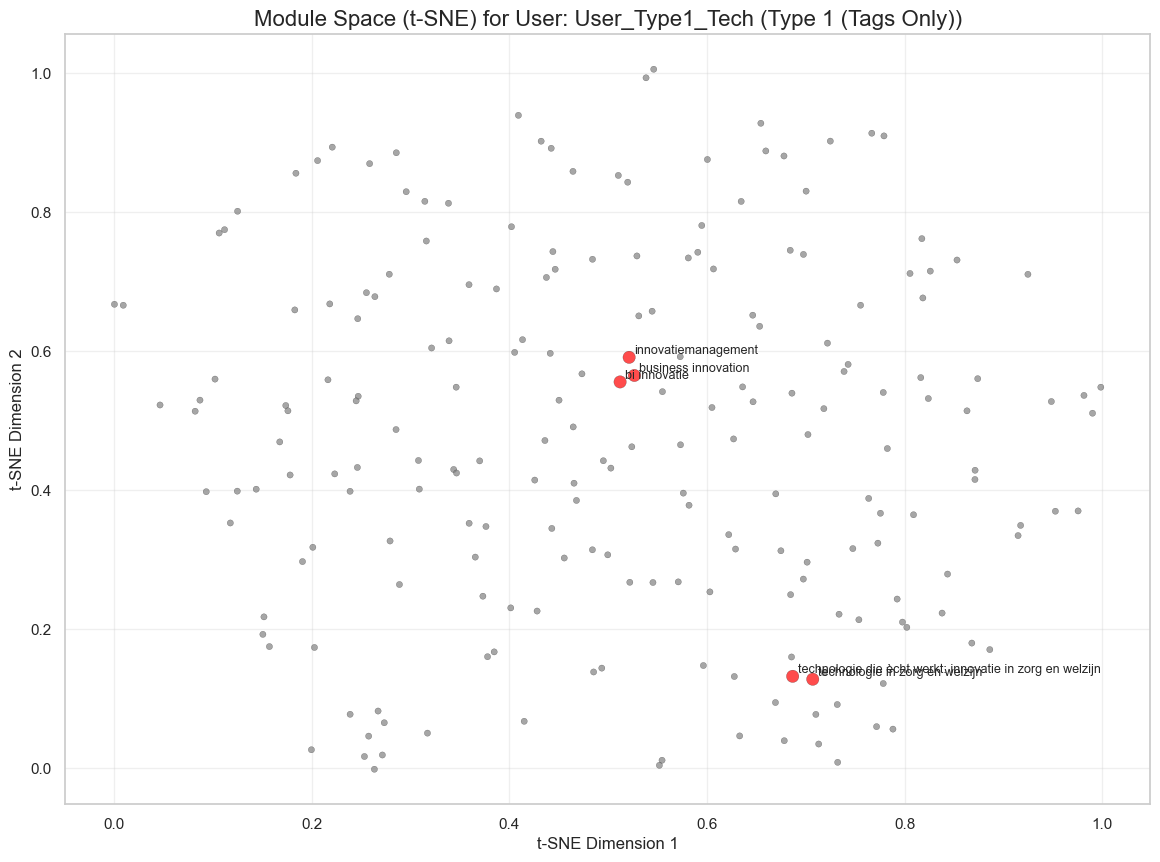

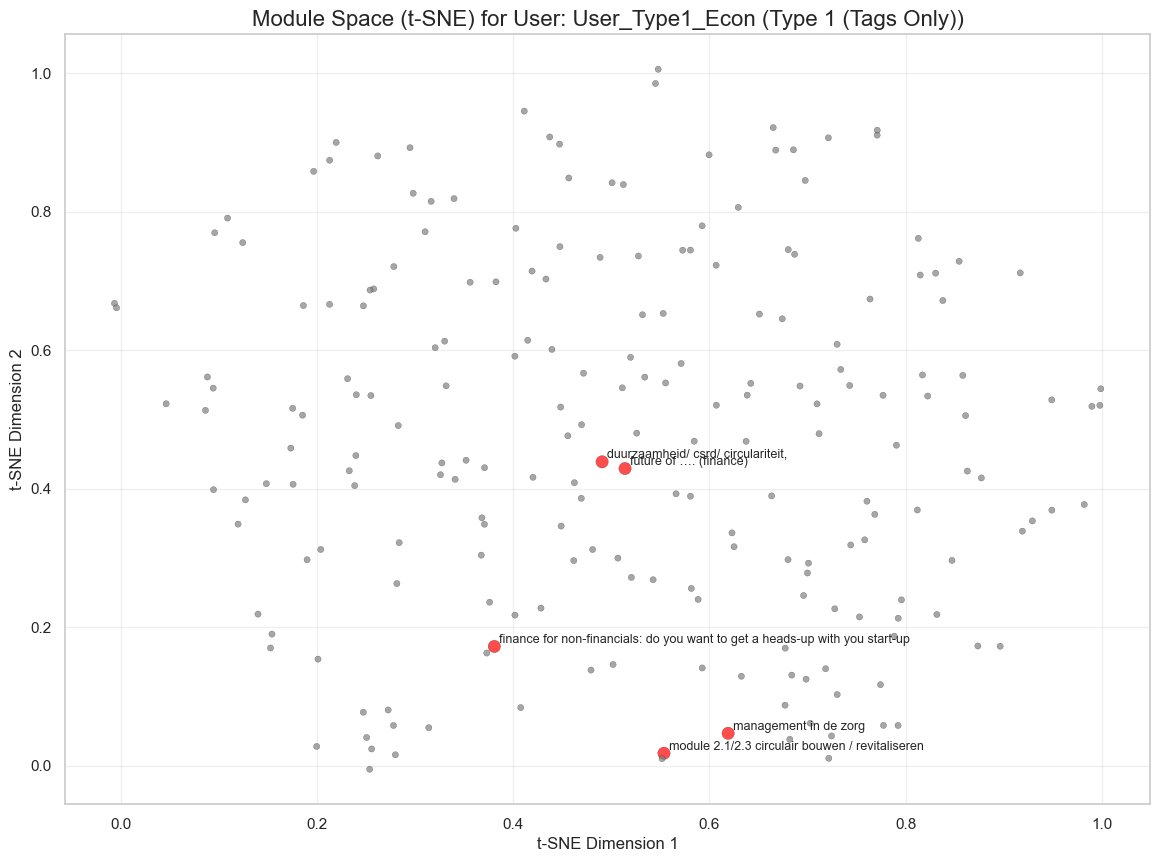

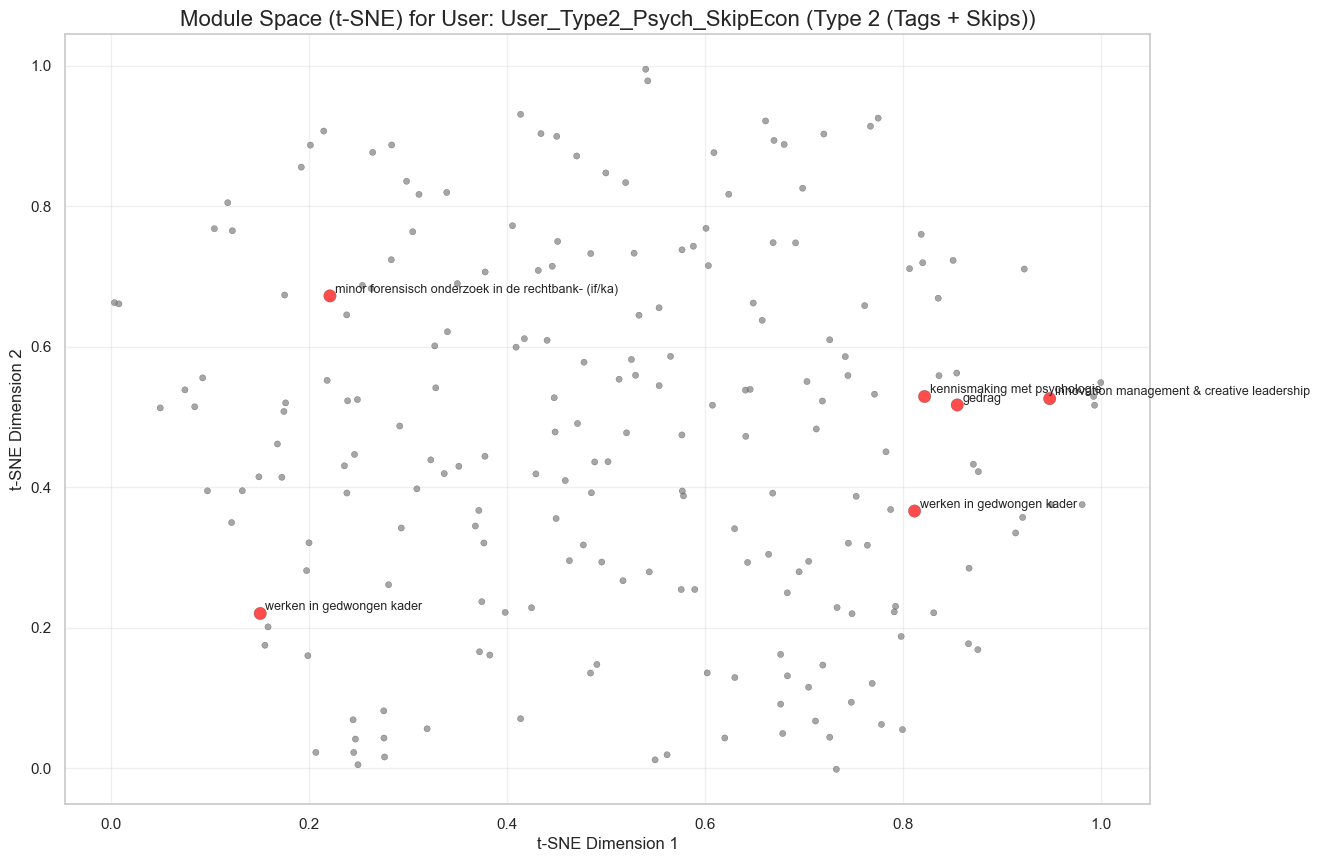

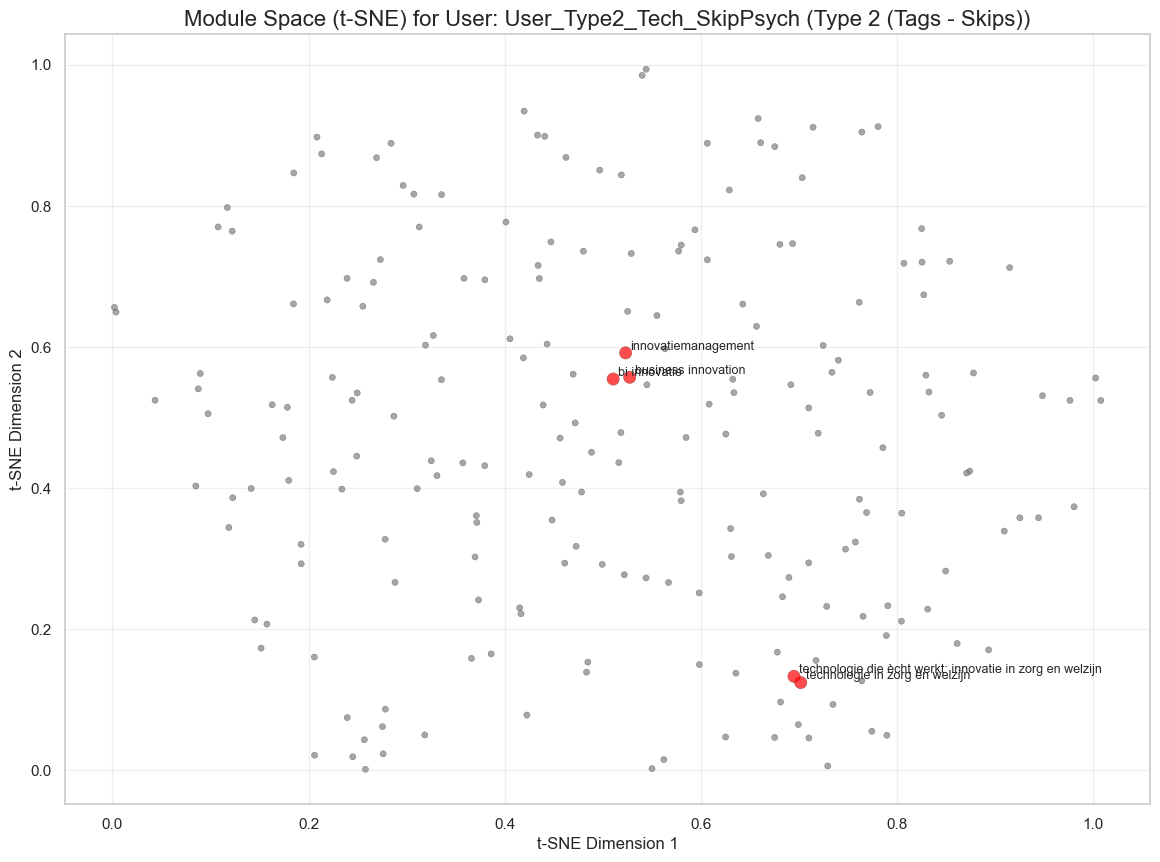

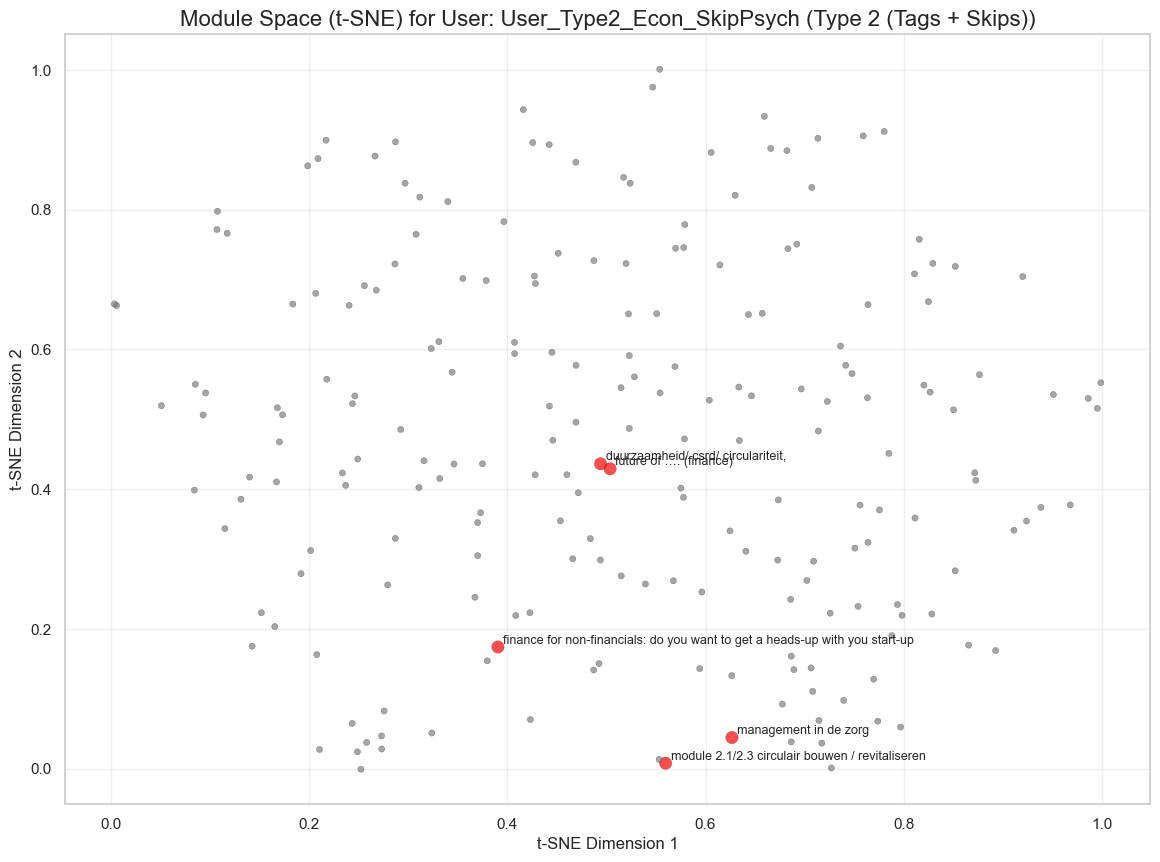

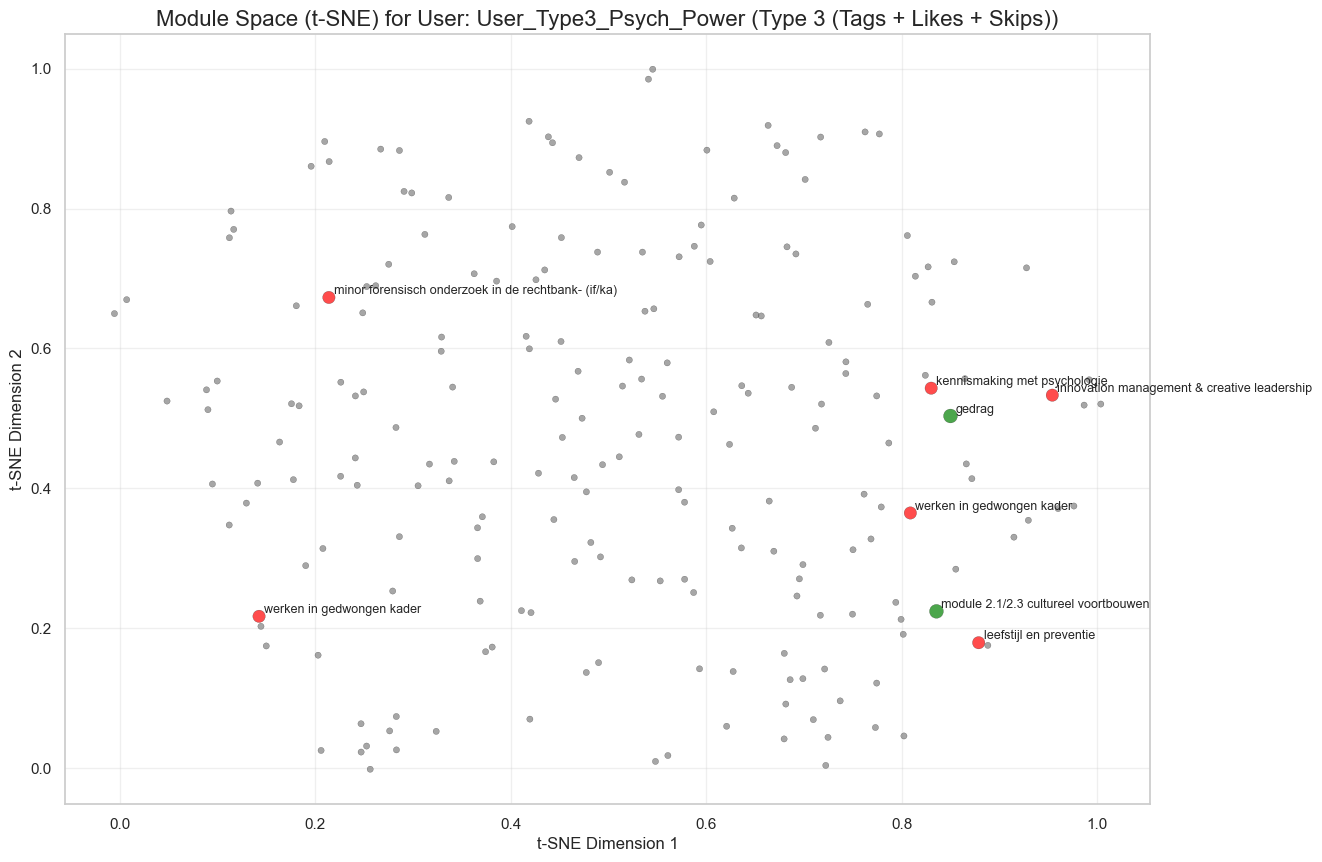

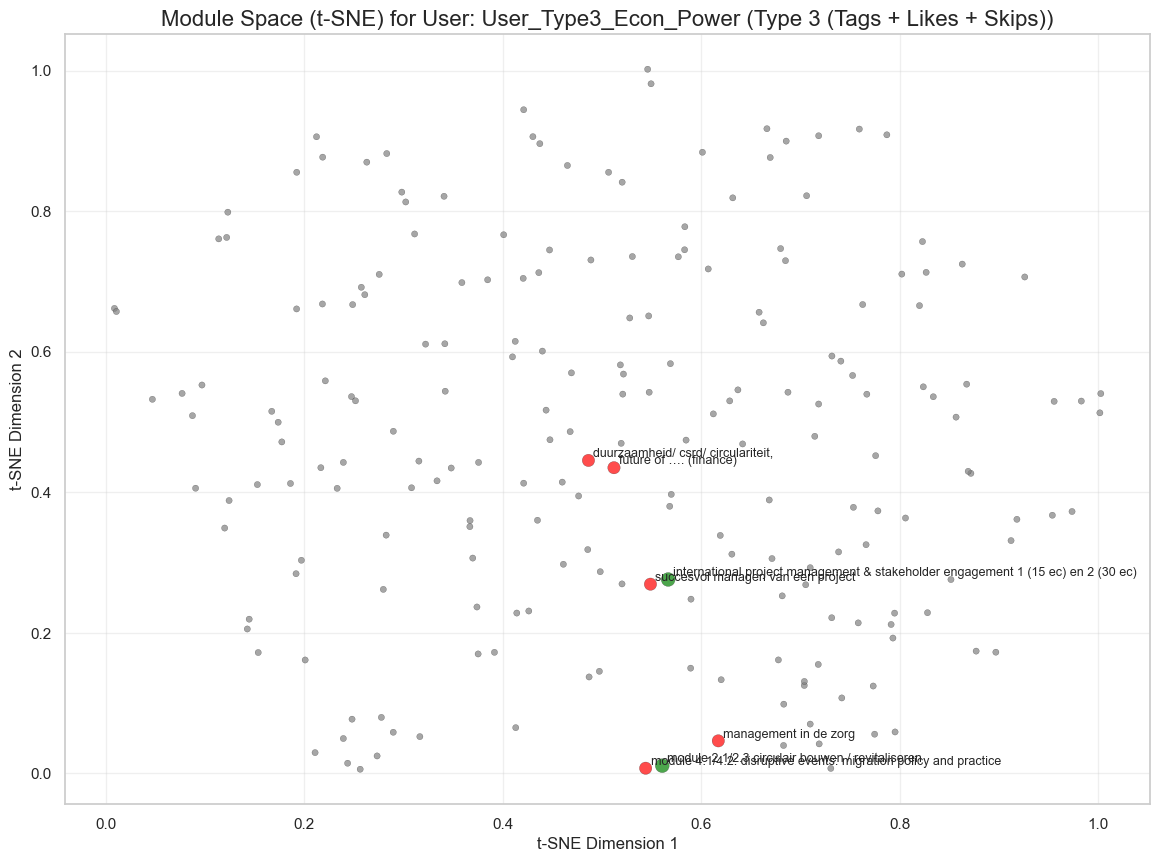

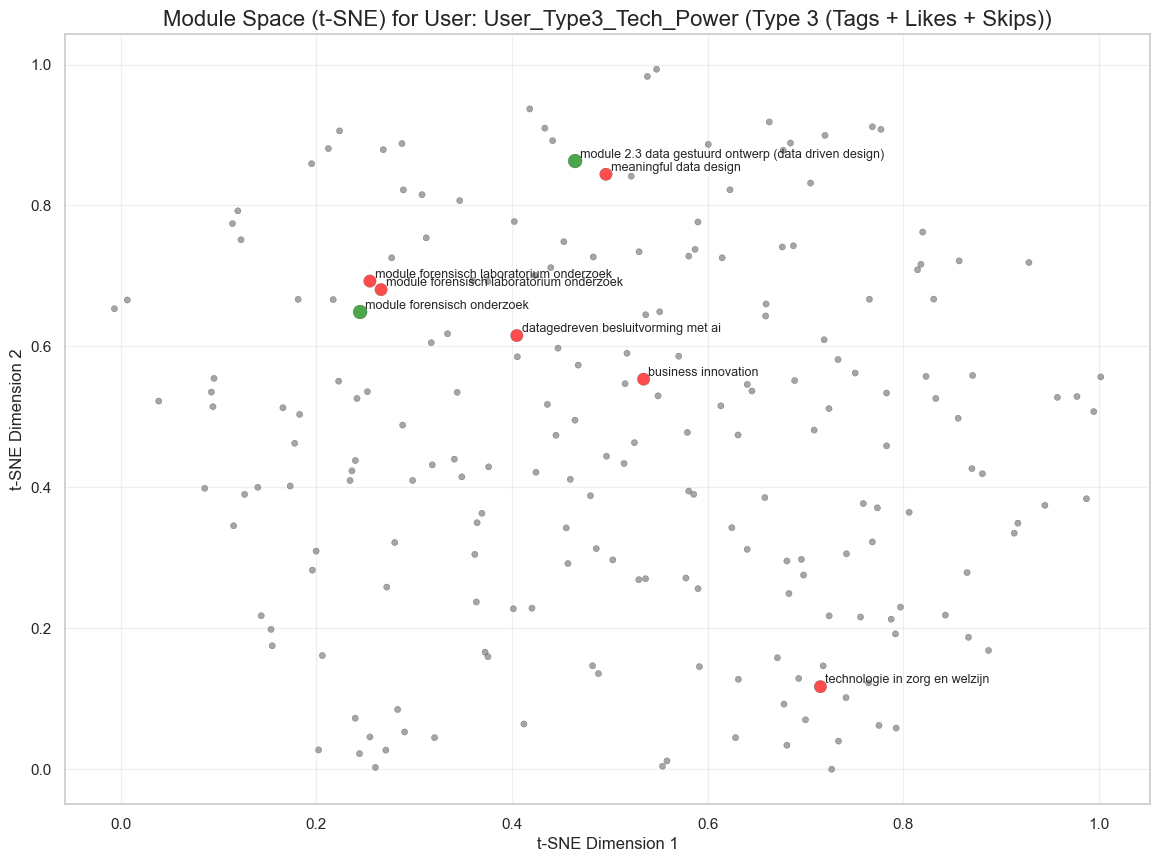

In [59]:

from sklearn.manifold import TSNE

def visualize_user_recommendations_tsne(
    user, df_clean, df_raw, vectorizer, matrix, top_n=5, perplexity=15, learning_rate=200, jitter=0.005
):
    """
    Visualize all modules in 2D using t-SNE, highlighting liked and recommended modules.
    
    Args:
        user: a test_user dictionary
        df: module dataframe
        vectorizer: fitted TF-IDF vectorizer
        matrix: TF-IDF matrix (sparse)
        top_n: number of recommendations
        perplexity: t-SNE perplexity parameter
        learning_rate: t-SNE learning rate
        jitter: small random noise to reduce overlap
    """
    # 1. Compute recommendations
    
    recs = recommend_to_user(
        user["input"]["favorite_tags"],
        user["input"]["liked_modules"],
        user["input"]["skipped_modules"],
        df_clean,
        df_raw,
        vectorizer,
        matrix,
        top_n=top_n
    )
    # for item in recs:        
    #         moduleName = item["module"]
    #         score = item["score"]
    #         explanations = item["explanation"]
    recommended_names = [item["module"] for item in recs]

    # 2. t-SNE embedding
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, learning_rate=learning_rate)
    reduced = tsne.fit_transform(matrix.toarray())

    # 3. Normalize to 0-1 range
    x = (reduced[:,0] - reduced[:,0].min()) / (reduced[:,0].max() - reduced[:,0].min())
    y = (reduced[:,1] - reduced[:,1].min()) / (reduced[:,1].max() - reduced[:,1].min())

    # 4. Add small jitter to reduce overlap
    x += np.random.normal(0, jitter, size=x.shape)
    y += np.random.normal(0, jitter, size=y.shape)

    # 5. Plotting
    plt.figure(figsize=(14,10))
    colors = []
    sizes = []

    for i, module_name in enumerate(df['name']):
        if module_name in user["input"]["liked_modules"]:
            colors.append('green')
            sizes.append(100)
        elif module_name in recommended_names:
            colors.append('red')
            sizes.append(80)
        else:
            colors.append('gray')
            sizes.append(20)

    plt.scatter(x, y, c=colors, s=sizes, alpha=0.7, edgecolor='k', linewidth=0.2)

    # Annotate liked and recommended modules
    for i, module_name in enumerate(df['name']):
        if module_name in user["input"]["liked_modules"] or module_name in recommended_names:
            plt.text(x[i]+0.005, y[i]+0.005, module_name, fontsize=9)

    plt.title(f"Module Space (t-SNE) for User: {user['id']} ({user['type']})", fontsize=16)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(alpha=0.3)
    plt.show()


# Example: visualize first test user
for user in test_users:
    visualize_user_recommendations_tsne(user, df_clean, df_raw, vectorizer, matrix, top_n=5)
